In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
%matplotlib inline
%config InlineBackend.figure_format ='retina'
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']
# See https://matplotlib.org/3.5.0/_images/sphx_glr_colormaps_006_2_0x.png

from simulation import *

import pickle

def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

%load_ext autoreload
%autoreload 2

In [2]:
from statsmodels.stats.proportion import proportion_confint

def read_data_omc(alpha=.05):
    dirc = 'data/surface_code_bitflip_lsd0_omc'
    fnames = os.listdir(dirc)
    dfs = []
    for fname in fnames:
        if fname.endswith('.pkl'):
            path = os.path.join(dirc, fname)
            data = read_pickle(path)
            d = data['d']
            p = data['p']
            df = data['df']
            
            num_fails = df['num_fails_cf'].values.cumsum()
            num_accepted = df['num_samples_cf'].values.cumsum()
            c = 1 - df.index
            num_samples = num_accepted[-1]
            
            mask = num_accepted > 0
            num_fails = num_fails[mask]
            num_accepted = num_accepted[mask]
            c = c[mask]

            pfail_low, pfail_upp = proportion_confint(num_fails,
                                                    num_accepted,
                                                    alpha=alpha,
                                                    method='wilson')
            pfail = (pfail_low + pfail_upp) / 2
            delta_pfail = pfail_upp - pfail
            
            pabort_low, pabort_upp \
                = proportion_confint(num_samples - num_accepted,
                                     num_samples,
                                     alpha=alpha,
                                     method='wilson')
            pabort = (pabort_low + pabort_upp) / 2
            delta_pabort = pabort_upp - pabort

            df_ps = pd.DataFrame({'c': c,
                                  'pfail': pfail,
                                  'delta_pfail': delta_pfail,
                                  'pabort': pabort,
                                  'delta_pabort': delta_pabort})
            df_ps['d'] = d
            df_ps['p'] = p
            df_ps = df_ps.set_index(['c', 'd', 'p']).sort_index()
            dfs.append(df_ps)
    
    dfs = pd.concat(dfs).sort_index()
    return dfs

In [139]:
df_mc = read_data_omc().loc[idx[0.9, :, :], :]
nonzero_prob_scale_e0_thrs = 1e-5

exclude_prms = {
    (0.9, 17, 0.19): 2741952543,
    (0.9, 17, 0.2): 9554594532,
    (0.9, 19, 0.18): 3307955529
}
exclude_prms = list(exclude_prms.keys())

prms = []
for index in df_mc.index:
    c, d, p = index
    if (c, d, p) in exclude_prms:
        continue
    pfail, delta_pfail = df_mc.loc[index, ['pfail', 'delta_pfail']]
    if delta_pfail > 0.005:
        pabort = df_mc.loc[index, 'pabort']
        if 1 - pabort > nonzero_prob_scale_e0_thrs:
            prob_scale_e0 = None
        else:
            paborts_lower_p = df_mc.loc[idx[c, d, :p], 'pabort']
            paborts_lower_p = paborts_lower_p[1 - paborts_lower_p >
                                              nonzero_prob_scale_e0_thrs]
            selected_p = paborts_lower_p.index[-1][2]
            prob_scale_e0 = selected_p / p
        prms.append((c, d, p, prob_scale_e0))
prms

[(0.9, 19, 0.19, 0.8947368421052632), (0.9, 19, 0.2, 0.85)]

In [154]:
import os

dirc = f'data/surface_code_bitflip_lsd0_mcmc'
os.makedirs(dirc, exist_ok=True)

def task(c, d, p, prob_scale_e0, chain_id, num_samples, batch_size, save):
    path = os.path.join(dirc, f'c{c}_d{d}_p{p}_{chain_id}.pkl')
    try:
        if not save:
            raise FileNotFoundError
        mcmc = MCMC.load(path)
        num_batches = round((num_samples - mcmc.shots) / batch_size)
    except FileNotFoundError:
        circuit = build_circuit_surface_code(d, 1, p_bitflip=p)
        mcmc = MCMC(c=c, circuit=circuit, e0_prob_scale=prob_scale_e0)
        num_batches = round(num_samples / batch_size)
    for _ in range(num_batches):
        mcmc.sample(batch_size, flip_single_qubit=False, adaptive_n_flip=False, n_flip=4)
        if save:
            mcmc.save(path)
    return mcmc

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm

Nc = 4
n_jobs = 8

tasks = list(
    delayed(task)(*prm, chain_id, round(1e9), round(1e6), True)
    for prm in prms for chain_id in range(Nc))
output = Parallel(n_jobs=n_jobs, verbose=1)(tasks)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


In [142]:
c, d, p = 0.9, 19, 0.15

circuit = build_circuit_surface_code(d, 1, p_bitflip=p)
mcmc_base = MCMC(c=c, circuit=circuit)

In [143]:
mcmcs = {0: mcmc_base}
for n_flip in [4, 5, 6]:
    mcmc = mcmc_base.copy()
    mcmcs[n_flip] = mcmc

In [144]:
T = 300
for n_flip, mcmc in mcmcs.items():
    print(n_flip)
    t0 = time.time()
    while True:
        mcmc.sample(10_000, flip_single_qubit=(n_flip == 0), n_flip=n_flip, adaptive_n_flip=False)
        if time.time() - t0 > T:
            break

0
4
5
6


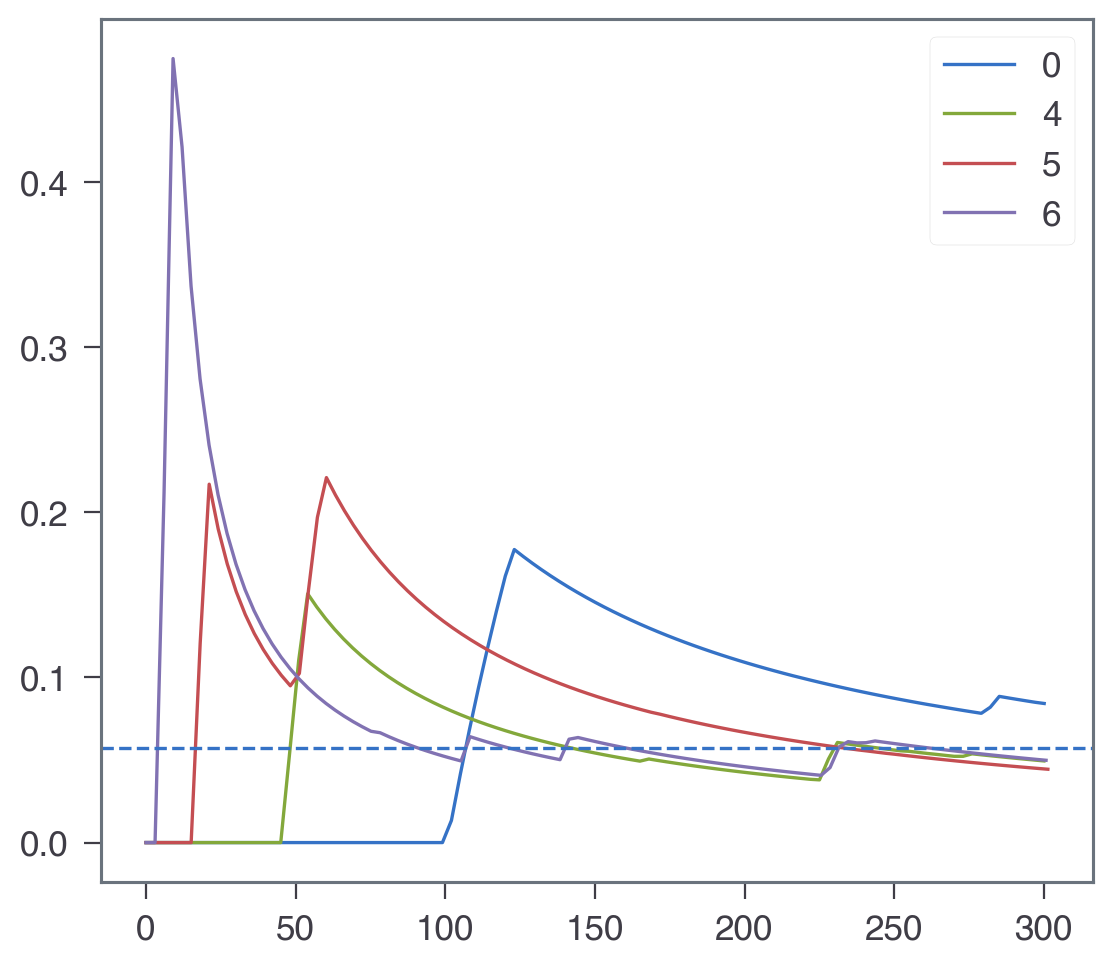

In [145]:
for n_flip, mcmc_sng in mcmcs.items():
#     if n_flip not in {0, 5}:
#         continue
    total_time = mcmc_sng.shots / mcmc_sng.sampling_rate
    x = np.linspace(0, total_time, mcmc_sng.shots)
    y = mcmc_sng.pfails_history
    index = np.arange(0, len(x), len(x) // 100)
    plt.plot(x[index], y[index], label=n_flip)

plt.axhline(0.057102, linestyle='--')
plt.legend()

In [146]:
esss = {}
for key, mcmc in mcmcs.items():
    ess = mcmc.ess
    esss[key] = ess
    print(key, ess, mcmc.eff_acc_rate, mcmc.acc_rate)

0 16.672444305511128 0.610519184578432 0.1652159782667572
4 49.45399844788276 0.4653815768683836 0.042077082747024645
5 41.78831810069741 0.4457000176064792 0.02626978653793723
6 80.09448642536434 0.40954447567851915 0.01586814275914474


In [ ]:
best_n_flips = {
    11: 6,
    13: 5
}